In [51]:
%matplotlib inline

In [52]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [53]:
import csv

data = open('../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

vol = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    vol[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

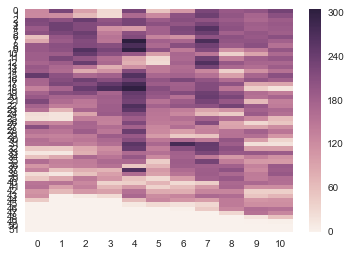

In [54]:
SLICE = 10

frame_x = pd.DataFrame(vol[SLICE,:,:])
frame_y = pd.DataFrame(vol[:,SLICE,:])
frame_z = pd.DataFrame(vol[:,:,SLICE])

sns.heatmap(frame_x)

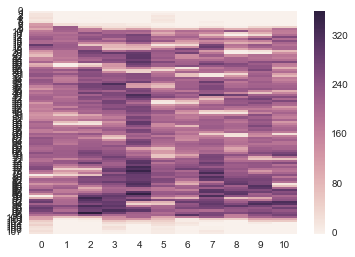

In [55]:
# And Y:
sns.heatmap(frame_y)

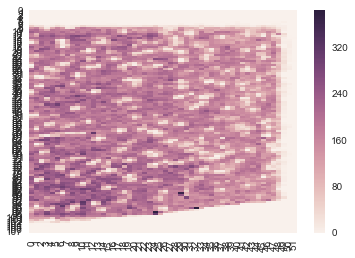

In [56]:
# And Z:
sns.heatmap(frame_z)

# 1. PCA
Let us begin by running PCA — we're 'satisfied' once we find $n$ st $sum(axis ratios) > \alpha \%$

In [57]:
from sklearn.decomposition import PCA

alpha = 0.99

n = 0
pca = PCA(n_components=n)
ratios = [0]
while sum(ratios) < alpha:
    n += 1
    pca = PCA(n_components=n)
    pca.fit(frame_z)
    ratios = pca.explained_variance_ratio_

print "{}% accounted for with n={} PCs".format(alpha, n)

0.99% accounted for with n=36 PCs


# 2. Orientation in Brain Space
We believe this to be a sample of V1, and as such, we believe this to be highly conformative to the layering structure of mammalian cortex.  To orient ourselves in cortical space, we anticipate finding a pial surface. Using [Bock et al. Nature (2011)](http://reid.med.harvard.edu/pdf/Bock-Lee-etal-Reid-2011-Nature.pdf), we can establish our bearings using ndviz.

This epithelial surface is clearly visible in [this view](http://viz.neurodata.io/bock11/xy/3/13325/2083/2917/), indicating that our $y$ axis is the cortical depth axis.

I expect learning more about PCA to get a better direction for axis than simply snapping to a cardinal axis.

![](http://openconnecto.me/ocp/catmaid/bock11/image/xy/2921/4_26_3.png)

# 3. Layer I Delimiterization
We believe that this dataset extends through layers I, II, III, and possibly part of IV. To determine this, we rely on the fact that mammalian cortex Layer I is *molecular*, and is thus low in synaptic density, compared to layer II. So there should be clear delimiterization along our $y$ axis:

In [58]:
y_sum = [0] * len(vol[0,:,0])
for i in range(len(vol[0,:,0])):
    y_sum[i] = sum(sum(vol[:,i,:]))

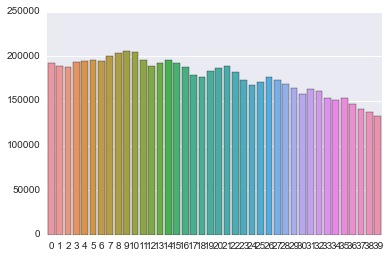

In [59]:
sns.barplot(x=range(len(y_sum[:40])), y=y_sum[:40])

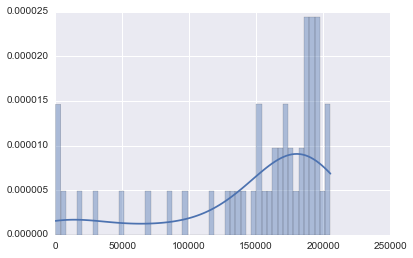

In [60]:
sns.distplot(y_sum, bins=len(y_sum))

Above, we see a histogram of `y_sum` that indicates that there is a local minimum at the 12th layer of y-sampling, which colocates with where we anticipate seeing the boundary between layers I and II. Here is the biological substantiation:

![image](https://cloud.githubusercontent.com/assets/693511/14183355/e9eafbd6-f73d-11e5-9769-8ce69e30774b.png)

As we can see, at about 1/3 of the 'depth' into cortex is the boundary to layer II.

# 4. Local maxima to find other cortical boundaries
Consider ![](https://upload.wikimedia.org/wikipedia/commons/5/5b/Cajal_cortex_drawings.png) these lamination illustrations (Ramon y Cajal) that show a 'wavelike' pattern to cellular density (and thus inversely, synaptic density). We see that our histogram follows this pattern:

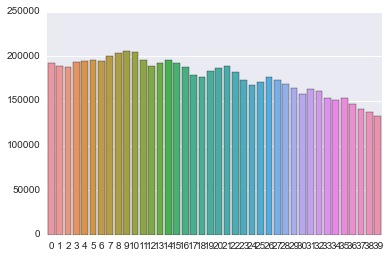

In [61]:
sns.barplot(x=range(len(y_sum[:40])), y=y_sum[:40])

Using these local maxima as delimiters, we can see a boundary at (12, 18, 24, 30), and then what is likely the boundary of Layer IVa/b at 33.

# 5. Do these layers stay approximately the same on different subvolumes?
Let's examine the layering, reviewed above:

In [62]:
from scipy.signal import argrelextrema
def local_minima(a):
    return argrelextrema(a, np.less)

whole_volume_minima = local_minima(np.array(y_sum))

In [63]:
whole_volume_minima

(array([ 2,  6, 12, 18, 24, 30, 34]),)

Now let's examine halves of the volume:

In [64]:
y_sum_left = [0] * len(vol[0,:,5:])
for i in range(len(vol[0,:,5:])):
    y_sum_left[i] = sum(sum(vol[:,i,5:]))
    
left_volume_minima = local_minima(np.array(y_sum_left))

In [65]:
y_sum_right = [0] * len(vol[0,:,:5])
for i in range(len(vol[0,:,:5])):
    y_sum_right[i] = sum(sum(vol[:,i,:5]))
    
right_volume_minima = local_minima(np.array(y_sum_right))

In [66]:
left_volume_minima, right_volume_minima

((array([ 2,  6,  9, 13, 18, 24, 27, 30, 33, 39, 42]),),
 (array([ 1,  4, 12, 17, 24, 28, 34]),))

Thus, we can see that the two halves are similar in terms of synaptic density minima along the y axis on opposite sides of the volume.